In [1]:
from PosSelect_Functions_Old import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import wilcoxon
from scipy.optimize import curve_fit
from scipy.stats import fisher_exact

hfont = {'fontname':'Arial'}
plt.rcParams["font.family"] = "Arial"

#Code borrowed heavily from here: https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
plt.rcParams.update(
    {"text.usetex": False}
)

#Overwrite version that removes LCR etc. because we do not have comparable annotations for bats etc.
def read_noncoding_data_fast(path = "./", maf_cut = 0.25, spec_sup = 250, phylop_cut = -100, pc = -1, dist = 500000000):
    
    v = pd.read_csv(path + "HumChp_NC_Final_NoHLA_ReadFast.txt", sep = "\t")
    vv = pd.read_csv(path + "HumPoly_NC_Final_NoHLA_ReadFast.txt", sep = "\t")
    vv = vv.drop_duplicates("Position")
    v = v[~v["Position"].isin(list(vv["Position"]))]

    #Only keep if we have the essential columns for this analysis
    v = v.dropna(subset = ["SpecSup447", "PhyloP447", "Position", "NearestGene", "NearestDist"])
    vv = vv.dropna(subset = ["SpecSup447", "PhyloP447", "Position", "NearestGene", "NearestDist"])

    v["PhyloP447"] = v["PhyloP447"].astype(float)
    vv["PhyloP447"] = vv["PhyloP447"].astype(float)
    v["SpecSup447"] = v["SpecSup447"].astype(int)
    vv["SpecSup447"] = vv["SpecSup447"].astype(int)
    v["PhastCons447"] = v["PhastCons447"].astype(float)
    vv["PhastCons447"] = vv["PhastCons447"].astype(float)

    v = v[v['PhastCons447'].astype(float) > pc]
    vv = vv[vv['PhastCons447'].astype(float) > pc]

    print(v.shape)

    v = v[v['SpecSup447'].astype(int) > spec_sup]
    vv = vv[vv['SpecSup447'].astype(int) > spec_sup]

    print(v.shape)

    v = v[v['PhyloP447'].astype(float) >= phylop_cut]
    vv = vv[vv['PhyloP447'].astype(float) >= phylop_cut]

    v = v[v['NearestDist'].astype(float) <= dist]
    vv = vv[vv['NearestDist'].astype(float) <= dist]

    print(v.shape)

    yvalls = vv[vv["MAFMaxAcrossAncestry"] >= maf_cut]
    yvalls = yvalls[yvalls["MAFMaxAcrossAncestry"] <= 1-maf_cut]

    v.index = v["NearestGene"]
    yvalls.index = yvalls["NearestGene"]

    v = v.drop_duplicates("Position")
    yvalls = yvalls.drop_duplicates("Position")
        
    return v, yvalls

#Define a logarithmic function to fit to the data
def plot_stuff(df, title, xlabel, ylabel):
    def func(x, a, c, d):
        return a + d*np.log(x + c)

    #Fit said function
    popt, pcov = curve_fit(func, xdata=df["AF bin"], ydata=df["Alpha"], maxfev = 100000)
    sns.scatterplot(x=df["AF bin"], y=df["Alpha"])
    xx = np.linspace(0.1, 1, 100)
    yy = func(xx, *popt)
    plt.title(title, size = 18)
    plt.xlabel(xlabel, size = 15)
    plt.ylabel(ylabel, size = 15)
    plt.plot(xx, yy)



C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Remove the data
maf_cut = 0.1
spec_sup = 250

#Local version does not remove NewTEs or LCRs as described above
v, yvalls = read_noncoding_data_fast(path = "./", maf_cut = maf_cut, spec_sup = spec_sup)
yvalls = add_unfold(yvalls)


(10748899, 6)
(5642872, 6)
(5642872, 6)


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:594: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_alt["UnfoldedMAF"] = 1-yvalls_alt["MAFMaxAcrossAncestry"]
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:595: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_ref["UnfoldedMAF"] = yvalls_ref["MAFMaxAcrossAncestry"]


In [3]:
orthos = pd.read_csv("Alecto_Musculus_Homo_Orthos.txt", sep = ',')
orthos = orthos.dropna()
orthos = orthos[(orthos["Mouse homology type"] == "ortholog_one2one") & (orthos["Megabat homology type"] == "ortholog_one2one")]
orthos = orthos.drop_duplicates("Gene stable ID")

orth2 = pd.read_csv("Orthologs_HumMouseMarm.txt", sep = "\t")
orth2 = orth2[["Gene stable ID", "Gene name"]]
orthos = orthos.set_index("Gene stable ID").join(orth2.set_index("Gene stable ID"))

In [4]:
#Read in UTR
vu, yvallsu = read_utr(maf_cut = 0.1, spec_sup = 250)
yvallsu = unfold_utr(yvallsu)

v_use = pd.concat([v, vu])
vv_use = pd.concat([yvalls, yvallsu])

v_use = v_use[v_use["NearestGene"].isin(orthos["Gene name"])]
vv_use = vv_use[vv_use["NearestGene"].isin(orthos["Gene name"])]


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:788: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  vv = pd.read_csv("HumPoly_UTR_Final.bed", sep = "\t")
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:796: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  p447 = pd.read_csv("447/HumChp_UTR_Final_NewPhyloP447.txt", sep = "\t").set_index("Position")
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:800: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  p447 = pd.read_csv("447/HumPoly_UTR_Final_NewPhyloP447.txt", sep = "\t").set_index("Position")


(163579, 10)
(162441, 10)
(162441, 10)
(162441, 10)
(120678, 10)


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_alt["UnfoldedMAF"] = 1-yvalls_alt["MAFMaxAcrossAncestry"]
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:883: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_ref["UnfoldedMAF"] = yvalls_ref["MAFMaxAcrossAncestry"]


In [5]:
#Restrict to orthologs
v_use = v_use[v_use["NearestGene"].isin(orthos["Gene name"])]
vv_use = vv_use[vv_use["NearestGene"].isin(orthos["Gene name"])]
vv_use

,Position,MAFMaxAcrossAncestry,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,Human ref,Human alt,Chimp ref,Gorilla ref,UnfoldedMAF,Gene,MskHumPhyloP,MskHBCGOPhyloP,SpeciesSupport,470MammalPhastCons,3or5
chr1:623755-T-G,chr1:623755,0.302751,SAMD11,301981.0,-0.058,0.0,336,T,G,T,T,0.302751,NaN,NaN,NaN,NaN,NaN,NaN
chr1:624752-C-T,chr1:624752,0.383673,SAMD11,300984.0,0.038,0.0,344,C,T,C,C,0.383673,NaN,NaN,NaN,NaN,NaN,NaN
chr1:627736-G-C,chr1:627736,0.105304,SAMD11,298000.0,-0.720,0.0,298,G,C,G,G,0.105304,NaN,NaN,NaN,NaN,NaN,NaN
chr1:627983-C-T,chr1:627983,0.225779,SAMD11,297753.0,-0.110,0.0,375,C,T,C,C,0.225779,NaN,NaN,NaN,NaN,NaN,NaN
chr1:628778-C-T,chr1:628778,0.129787,SAMD11,296958.0,-0.226,0.0,345,C,T,C,C,0.129787,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:155053587-A-T,chrX:155053587,0.513391,MTCP1,17599.0,0.236,0.001,311,A,T,T,T,0.486609,NaN,NaN,NaN,NaN,NaN,NaN
chrX:155211883-T-C,chrX:155211883,0.610736,VBP1,4562.0,1.814,0.0,278,T,C,C,C,0.389264,NaN,NaN,NaN,NaN,NaN,NaN
chrX:155223101-C-G,chrX:155223101,0.539902,VBP1,6656.0,-0.151,0.0,284,C,G,G,G,0.460098,NaN,NaN,NaN,NaN,NaN,NaN
chrX:155256667-G-A,chrX:155256667,0.766725,RAB39B,7830.0,-0.135,0.0,391,G,A,A,A,0.233275,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y


(-0.014188176866580693, 1.991, [[217710, 4198377], [31066, 590743]], [[217907, 4198180], [31098, 590711]], <Figure size 1000x600 with 1 Axes>)


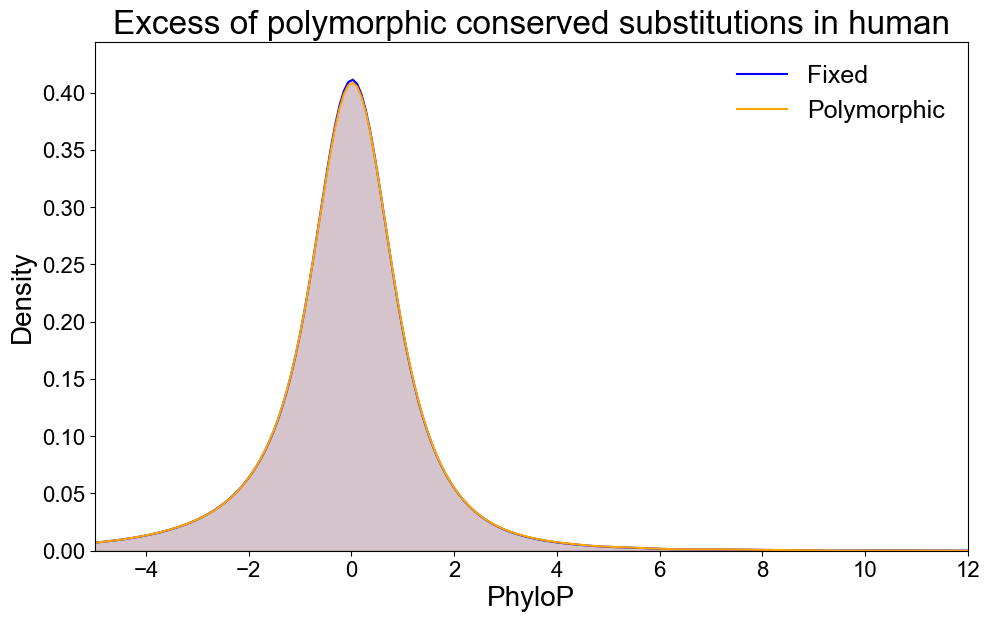

In [6]:
vv_use2 = vv_use[vv_use["UnfoldedMAF"] > 0.5]
vvv = prepare_alpha(v_use, vv_use2)
yvals2 = [np.float64(j) for j in list(vv_use2["PhyloP447"])]
yvals2.sort()
cuttt = 0.95
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, cutoff = cutoff, plot = True, title = "Excess of polymorphic conserved substitutions in human")
print(alpha)

C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y


(-0.014188176866580693, 1.991, [[217710, 4198377], [31066, 590743]], [[217907, 4198180], [31098, 590711]], <Figure size 1000x600 with 1 Axes>)


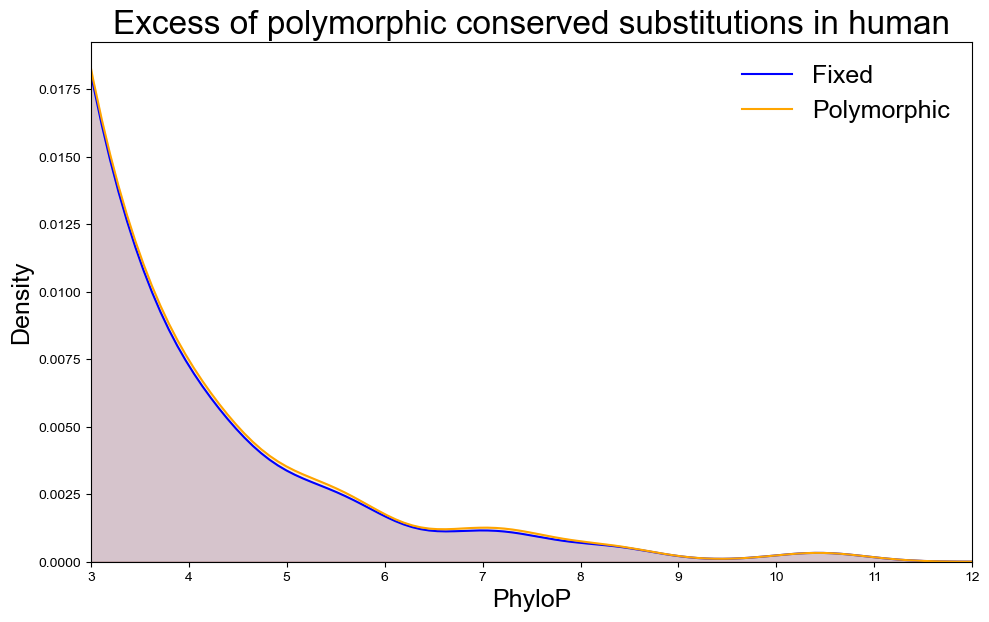

In [8]:
vv_use2 = vv_use[vv_use["UnfoldedMAF"] > 0.5]
vvv = prepare_alpha(v_use, vv_use2)
yvals2 = [np.float64(j) for j in list(vv_use2["PhyloP447"])]
yvals2.sort()
cuttt = 0.95
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, cutoff = cutoff, plot = True, title = "Excess of polymorphic conserved substitutions in human", window = [3, 12])
print(alpha)

C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.008090747077917959


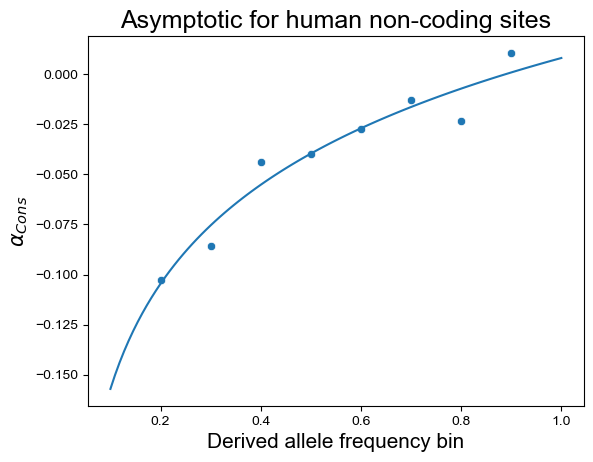

In [8]:
alpha, to_plot = asymptotic_unfold_cutoff(v_use, vv_use, start = 0.1, dn_cut = 0.0001, to_plot_curve = False, cuttt = 0.95)
plot_stuff(to_plot, title = "Asymptotic for human non-coding sites", ylabel = "$\\alpha_{Cons}$", xlabel = "Derived allele frequency bin")
print(alpha)